# Explore Level-2 Ocean Color Data from the Moderate Resolution Imaging Spectroradiometer (MODIS)

**Authors:** Guoqing Wang (NASA, GSFC), Ian Carroll (NASA, UMBC), Eli Holmes (NOAA), Anna Windle (NASA, GSFC)

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

[edl]: https://urs.earthdata.nasa.gov/

## Summary

This tutorial demonstrates accessing and analyzing NASA ocean color data using Python from the NASA Ocean Biology Distributed Active Archive Center (OB.DAAC) archives. Currently, there are several ways to find and access ocean color data:

1. [NASA's Earthdata Search](https://search.earthdata.nasa.gov/search)
1. [NASA's CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html)
1. [OB.DAAC OPENDAP](https://oceandata.sci.gsfc.nasa.gov/opendap/)
1. [OB.DAAC File Search](https://oceandata.sci.gsfc.nasa.gov/api/file_search_help)

In this tutorial, we will focus on using `earthaccess` Python module to access MODIS Aqua ocean color data through NASA's Common Metadata Repository (CMR), a metadata system that catalogs Earth Science data and associated metadata records. The level 2 dataset of MODIS Aqua is one of the most popular datasets of OB.DAAC. Here we will use MODIS Aqua L2 Chlorophyll *a* data of the Chesapeake Bay as an example.
The standard NASA ocean color Chlorophyll *a* algorithm is described in the [Algorithm Theoretical Basis Document (ATBD)](https://www.earthdata.nasa.gov/apt/documents/chlor-a/v1.0).

## Learning Objectives

At the end of this notebok you will know:
* How to find OB.DAAC ocean color data
* How to download files using `earthaccess`
* How to create a plot using `xarray`

## Contents

1. [Setup](#setup)
1. [NASA Earthdata Authentication](#auth)
1. [Search for Data](#search)
1. [Download Data](#download)
1. [Plot Data](#plot)

<a name="setup"></a>

## 1. Setup

We begin by importing all of the packages used in this notebook. If you have created an environment following the [guidance][tutorials] provided with this tutorial, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials

In [1]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from IPython.display import JSON
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyresample
from pyresample import geometry, kd_tree

/Users/jessecox/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[back to top](#contents) <a name="auth"></a>

## 2. NASA Earthdata Authentication

Next, we authenticate using our Earthdata Login
credentials. Authentication is not needed to search publicaly
available collections in Earthdata, but is always needed to access
data. We can use the `login` method from the `earthaccess`
package. This will create an authenticated session when we provide a
valid Earthdata Login username and password. The `earthaccess`
package will search for credentials defined by **environmental
variables** or within a **.netrc** file saved in the home
directory. If credentials are not found, an interactive prompt will
allow you to input credentials.

<div class="alert alert-info" role="alert">
The <code>persist=True</code> argument ensures any discovered credentials are
stored in a <code>.netrc</code> file, so the argument is not necessary (but
it's also harmless) for subsequent calls to <code>earthaccess.login</code>.
</div>

In [2]:
auth = earthaccess.login(persist=True)

[back to top](#contents) <a name="search"></a>

## 3. Search for Data

The MODIS instrument, on board the Aqua satellite, collects ocean color data, processed from Level-1 through Level-4 and distributed by the OB.DAAC. In this example, we will use the standard Chlorophyll a data from Level-2 ocean color files. To find data we will use the `earthaccess` Python library to search on NASA's CMR API.

NASA data collections, i.e. a series of related granules, are discoverable with `earthaccess.search_datasets`. Various search parameters can be used to search collections and granules using metadata attributes. See more details [here](https://github.com/nsidc/earthaccess/blob/main/notebooks/Demo.ipynb). Below, CMR Catalog are queried to find collections with **"L2 ocean color"** keyword in them, with the **MODIS** instrument. The returned response can be used to retrieve the `ShortName` and `concept-id` for each dataset.

In [3]:
results = earthaccess.search_datasets(
    keyword="L2 ocean color",
    instrument="MODIS",
)

Each result has a `summary` method with information such as the collection's short-name.

In [4]:
set((i.summary()["short-name"] for i in results))

{'MODISA_L2_IOP',
 'MODISA_L2_IOP_NRT',
 'MODISA_L2_OC',
 'MODISA_L2_OC_NRT',
 'MODISA_L2_SST',
 'MODISA_L2_SST4',
 'MODISA_L2_SST4_NRT',
 'MODISA_L2_SST_NRT',
 'MODIST_L2_IOP',
 'MODIST_L2_IOP_NRT',
 'MODIST_L2_OC',
 'MODIST_L2_OC_NRT',
 'MODIST_L2_SST',
 'MODIST_L2_SST4',
 'MODIST_L2_SST4_NRT',
 'MODIST_L2_SST_NRT'}

We are interested in the `MODISA_L2_OC` dataset.

We can use spatial and temporal arguments to search for granules covering Chesapeake Bay during the time frame of Oct 15 - 23, 2020. We can also add the cloud_cover parameter to filter out granules with too much cloud coverage.
cloud_cover = (0, 50) # max 50% of cloud coverage

In [5]:
tspan = ("2020-10-15", "2020-10-23")
bbox = (-83.5, 41.3, -82.3, 42.2)
cc = (0, 50)

In [6]:
results = earthaccess.search_data(
    short_name="MODISA_L2_OC",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=cc,
)

Now we can print some info about these granules using the built-in methods. We can see how each result prefers to display itself.

In [7]:
results[0]

Collection: {'Version': '2022.0', 'ShortName': 'MODISA_L2_OC'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 47.42275, 'Longitude': -81.93353}, {'Latitude': 43.2218, 'Longitude': -111.34791}, {'Latitude': 26.0838, 'Longitude': -103.24541}, {'Latitude': 29.41412, 'Longitude': -79.92866}, {'Latitude': 47.42275, 'Longitude': -81.93353}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-10-16T19:25:00Z', 'EndingDateTime': '2020-10-16T19:29:59Z'}}
Size(MB): 26.07148551940918
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20201016T192500.L2.OC.nc']

Or we could use the `data_links` and `size` methods provided on each result.

In [8]:
data_links = [{"links": i.data_links(), "size (MB):": i.size()} for i in results]
JSON(data_links, expanded=True)

<IPython.core.display.JSON object>

Or we can interactively inspect all the fields underlying a result.

In [9]:
JSON(results)

<IPython.core.display.JSON object>

[back to top](#contents) <a name="download"></a>

## 4. Download Data

Since the data are not hosted in the Earthdata Cloud (see output from `results[0]` above), we need to download files. This will download the data in a folder called "data" in your working directory.

In [10]:
paths = earthaccess.download(results, "data")

QUEUEING TASKS | : 100%|████████████████████████| 2/2 [00:00<00:00, 5074.78it/s]
PROCESSING TASKS | : 100%|█████████████████████| 2/2 [00:00<00:00, 20360.70it/s]
COLLECTING RESULTS | : 100%|███████████████████| 2/2 [00:00<00:00, 41734.37it/s]


[back to top](#contents) <a name="plot"></a>

## 5. Plot Data

Step-by-step, we'll build a nice map showing the log-transformed chlorophyll a estimate for the first granule we
downloaded. The first step is to open some of the "groups" present within the NetCDF files to begin preparing
a variable to plot.

In [11]:
prod = xr.open_dataset(paths[0])
obs = xr.open_dataset(paths[0], group="geophysical_data")
nav = xr.open_dataset(paths[0], group="navigation_data")

The "navigation_data" group has geospatial coordinates that we merge into the "geophysical_data" group, which has the
"chlor_a" product.

In [12]:
nav = (
    nav
    .set_coords(("longitude", "latitude"))
    .rename({"pixel_control_points": "pixels_per_line"})
)
dataset = xr.merge((prod, obs, nav.coords))

In [22]:
dataset

<xarray.Dataset> Size: 242MB
Dimensions:    (number_of_lines: 2030, pixels_per_line: 1354)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 11MB -79.93 ... -111.3
    latitude   (number_of_lines, pixels_per_line) float32 11MB 29.41 ... 43.24
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables: (12/20)
    aot_869    (number_of_lines, pixels_per_line) float32 11MB ...
    angstrom   (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_412    (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_443    (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_469    (number_of_lines, pixels_per_line) float32 11MB ...
    Rrs_488    (number_of_lines, pixels_per_line) float32 11MB ...
    ...         ...
    pic        (number_of_lines, pixels_per_line) float32 11MB ...
    poc        (number_of_lines, pixels_per_line) float32 11MB ...
    ipar       (number_of_lines, pixels_per_line) float32 11MB ...
    nflh       (number_of_lines, pixels_per_line) float32 11MB ...
    par        (number_of_lines, pixels_per_line) float32 11MB ...
    l2_flags   (number_of_lines, pixels_per_line) int32 11MB ...
Attributes: (12/48)
    title:                          MODISA Level-2 Data
    product_name:                   AQUA_MODIS.20201016T192500.L2.OC.nc
    processing_version:             R2022.0
    equatorCrossingLongitude:       82.23992
    orbit_number:                   98160
    history:                        l2gen par=/data1/sdpsoper/vdc/vpu0/workbu...
    ...                             ...
    geospatial_lon_max:             -79.92866
    geospatial_lon_min:             -111.34791
    startDirection:                 Ascending
    endDirection:                   Ascending
    day_night_flag:                 Day
    earth_sun_distance_correction:  1.0067232847213745

Now, we can pull out and fine-tune the "chlor_a" variable for visualization.

In [13]:
array = dataset["Rrs_555"]
array.attrs.update(
    {
        "units": f'({dataset["Rrs_555"].attrs["units"]})',
    }
)

The `plot` method from XArray's plotting API is an easy way to take an `xr.Dataset` or `xr.DataArray` to
a `matplotlib` figure.

In [15]:
# Flatten the swath lat/lon
lons = array['longitude'].values.flatten()
lats = array['latitude'].values.flatten()
data = array.values.flatten()

# Mask out NaNs
valid_mask = ~np.isnan(data) & ~np.isnan(lons) & ~np.isnan(lats)
lons = lons[valid_mask]
lats = lats[valid_mask]
data = data[valid_mask]

# Define swath
swath_def = geometry.SwathDefinition(lons=lons, lats=lats)

# Define target grid (regular lat/lon)
target_lons = np.arange(-180, 180, 0.01)  # Choose region bounds/resolution
target_lats = np.arange(-90, 90, 0.01)
lon2d, lat2d = np.meshgrid(target_lons, target_lats)
area_def = geometry.GridDefinition(lons=lon2d, lats=lat2d)

# Regrid (nearest-neighbor)
result = kd_tree.resample_nearest(
    swath_def, data, area_def,
    radius_of_influence=5000,  # in meters
    fill_value=np.nan
)

# Create xarray DataArray
regridded = xr.DataArray(
    result,
    dims=("latitude", "longitude"),
    coords={"latitude": target_lats, "longitude": target_lons},
    name="Rrs_555"
)

# Define bounding box
min_lon, max_lon = -83.5, -82.3
min_lat, max_lat = 41.3, 42.2

# Subset the data
regridded = regridded.sel(
    longitude=slice(min_lon, max_lon),
    latitude=slice(min_lat, max_lat)  # NOTE: latitude usually goes from high to low!
)
regridded

<xarray.DataArray 'Rrs_555' (latitude: 90, longitude: 120)> Size: 43kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 720B 41.3 41.31 41.32 ... 42.17 42.18 42.19
  * longitude  (longitude) float64 960B -83.49 -83.48 -83.47 ... -82.31 -82.3

In [16]:
bbox

(-83.5, 41.3, -82.3, 42.2)

In [17]:
min_lat = bbox[1]
max_lat = bbox[3]
min_lon = bbox[0]
max_lon = bbox[2]

We can enrich the visualiation using `matplotlib` and `cartopy`. The coordinates are latitude and longitude, so if we add the "Plate Carree" coordinate reference system (CRS) to our axes, we will get an improved map.

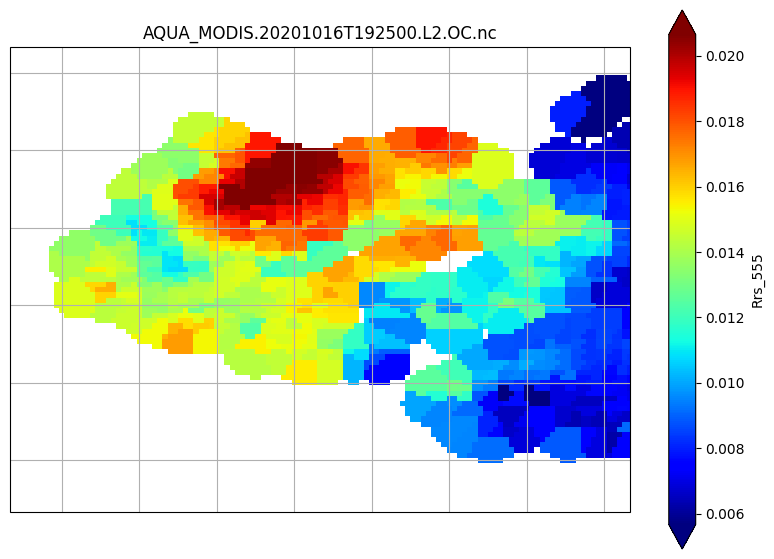

In [18]:
fig = plt.figure(figsize=(10, 7), dpi = 100)
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent: [west_lon, east_lon, south_lat, north_lat]
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Plot the data
# Downsample if needed (e.g., every 5th point)
regridded_plot = regridded.isel(latitude=slice(None, None, 1), longitude=slice(None, None, 1))
vmin = float(regridded_plot.quantile(0.02))
vmax = float(regridded_plot.quantile(0.98))
regridded_plot.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax)


# Add gridlines
gl = ax.gridlines(draw_labels=False)
gl.right_labels = False
gl.top_labels = False

# Add state borders
# ax.add_feature(cfeature.STATES, linewidth=0.5)

# Set title
ax.set_title(dataset.attrs["product_name"], loc="center")

plt.show()

[back to top](#contents)

<div class="alert alert-info" role="alert">

You have completed the notebook on Aqua/MODIS L2 data exploration.

</div>

In [19]:
print(array)

<xarray.DataArray 'Rrs_555' (number_of_lines: 2030, pixels_per_line: 1354)> Size: 11MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 11MB -79.93 ... -111.3
    latitude   (number_of_lines, pixels_per_line) float32 11MB 29.41 ... 43.24
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:         Remote sensing reflectance at 555 nm
    units:             (sr^-1)
    standard_name:     surface_ratio_of_upwelling_radiance_emerging_from_sea_...
    valid_min:         -30000
    valid_max:         25000
    solar_irradiance:  1837.5674


In [20]:
print(array.coords)

Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 11MB -79.93 ... -111.3
    latitude   (number_of_lines, pixels_per_line) float32 11MB 29.41 ... 43.24


In [21]:
print(array.attrs)

{'long_name': 'Remote sensing reflectance at 555 nm', 'units': '(sr^-1)', 'standard_name': 'surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_downwelling_radiative_flux_in_air', 'valid_min': np.int16(-30000), 'valid_max': np.int16(25000), 'solar_irradiance': np.float32(1837.5674)}
